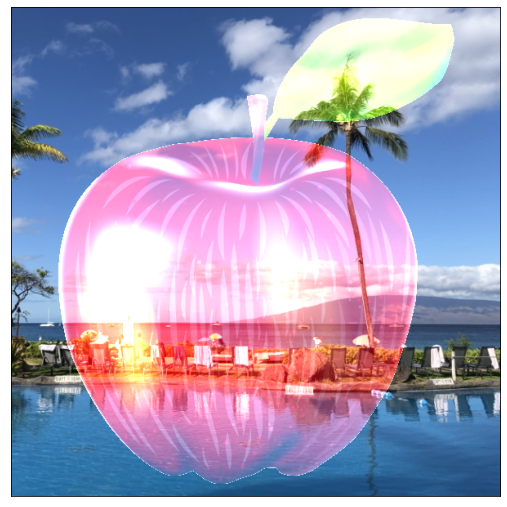

In [45]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

#fg = np.array(Image.open('Data/apple.png'))
#bg = np.array(Image.open('Data/apple-bg.jpg'))

fg = Image.open('Data/apple.png')
bg = Image.open('Data/apple-bg.jpg')

fg = np.array(fg)
bg = np.array(bg)

#fg = cv2.cvtColor(fg, cv2.COLOR_BGR2BGRA)
bg = cv2.cvtColor(bg, cv2.COLOR_BGR2BGRA)

bg = cv2.addWeighted(fg, 1.0, bg, 1.0, 0)

_, ax = plt.subplots(1, figsize=(12,9), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(bg)

In [48]:
def blend_transparent(face_img, overlay_t_img):
    # Split out the transparency mask from the colour info
    overlay_img = overlay_t_img[:,:,:3] # Grab the BRG planes
    overlay_mask = overlay_t_img[:,:,3:]  # And the alpha plane

    # Again calculate the inverse mask
    background_mask = 255 - overlay_mask

    # Turn the masks into three channel, so we can use them as weights
    overlay_mask = cv2.cvtColor(overlay_mask, cv2.COLOR_GRAY2BGR)
    background_mask = cv2.cvtColor(background_mask, cv2.COLOR_GRAY2BGR)

    # Create a masked out face image, and masked out overlay
    # We convert the images to floating point in range 0.0 - 1.0
    face_part = (face_img * (1 / 255.0)) * (background_mask * (1 / 255.0))
    overlay_part = (overlay_img * (1 / 255.0)) * (overlay_mask * (1 / 255.0))

    # And finally just add them together, and rescale it back to an 8bit integer image    
    return np.uint8(cv2.addWeighted(face_part, 255.0, overlay_part, 255.0, 0.0))

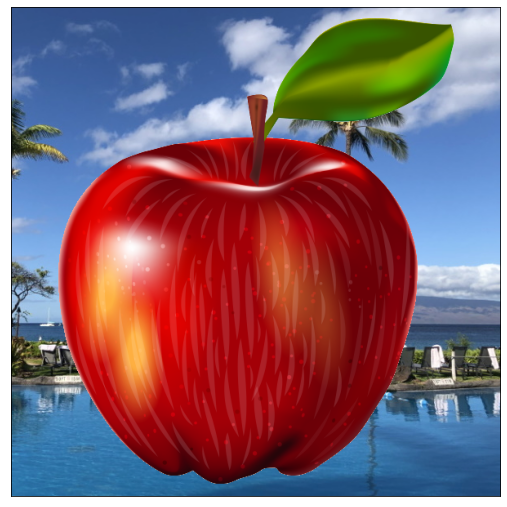

In [50]:
fg = Image.open('Data/apple.png')
bg = Image.open('Data/apple-bg.jpg')

fg = np.array(fg)
bg = np.array(bg)

#fg = cv2.cvtColor(fg, cv2.COLOR_BGR2BGRA)
#bg = cv2.cvtColor(bg, cv2.COLOR_BGR2BGRA)

image = blend_transparent(bg, fg)
_, ax = plt.subplots(1, figsize=(12,9), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)